
# BCCD Cell Instance Segmentation — Step‑by‑Step Notebook (UPDATED)

**How to use:** run cells in order. Each section corresponds to a step in your pipeline and saves visualizations into a `viz/` folder (inside your project directory).  
If you're on **Google Colab**:
1) Runtime → Change runtime type → **GPU**.  
2) Run the '0A. Optional installs' (only on a fresh Colab).  
3) Run '1. Imports & Config', then continue downwards one section at a time.

---


In [1]:

# 0A) Optional installs (uncomment if needed on a fresh Colab)
# !pip -q install kagglehub albumentations opencv-python scikit-image pycocotools timm --upgrade
# !pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121


## 1) Imports & Config

In [2]:

import os, json, random, time, math
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from skimage import color
from skimage.measure import label as cc_label, regionprops

import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torch.amp import GradScaler, autocast

# ------------------ Config ------------------
USE_DRIVE = True
FAST_DEV  = True
VIZ_SAVE  = True
EPOCHS    = 3 if FAST_DEV else 12
BATCH_SZ  = 2 if FAST_DEV else 4
IMG_SIZE  = 384 if FAST_DEV else 512
LR        = 1e-4
USE_AMP   = torch.cuda.is_available()  # AMP only if CUDA
NUM_WORK  = 2 if FAST_DEV else 4
PRINT_EVERY = 10

MAX_IMAGES = 100          # cap total images for quick runs
RATIOS_SPLIT = (0.70, 0.15, 0.15)  # train/val/test

# ---------- Paths ----------
PROJECT_DIR = "/content/drive/MyDrive/bccd_instance_seg" if USE_DRIVE else "/content/bccd_instance_seg"
SPLITS_JSON = f"{PROJECT_DIR}/bccd_splits_100.json"
CKPT_DIR    = f"{PROJECT_DIR}/checkpoints"
VIZ_DIR     = f"{PROJECT_DIR}/viz"

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
    except Exception:
        print("Drive mount failed; using local storage.")
        USE_DRIVE = False
        PROJECT_DIR = "/content/bccd_instance_seg"
        SPLITS_JSON = f"{PROJECT_DIR}/bccd_splits_100.json"
        CKPT_DIR    = f"{PROJECT_DIR}/checkpoints"
        VIZ_DIR     = f"{PROJECT_DIR}/viz"

os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

# ---------- Repro / Device ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)




Mounted at /content/drive
Device: cuda


## 2) Step 1 — Dataset download & small deterministic splits (+ viz)

100%|██████████| 2.15G/2.15G [01:15<00:00, 30.4MB/s]

Extracting files...


kagglehub base: /root/.cache/kagglehub/datasets/jeetblahiri/bccd-dataset-with-mask/versions/1
Found total candidate pairs: 1169
Readable pairs: 1169 | dropped: 0
Split sizes: {'train': 70, 'val': 15, 'test': 15}
Small split sizes (final): {'train': 70, 'val': 15, 'test': 15}


NameError: name 'save_or_show' is not defined

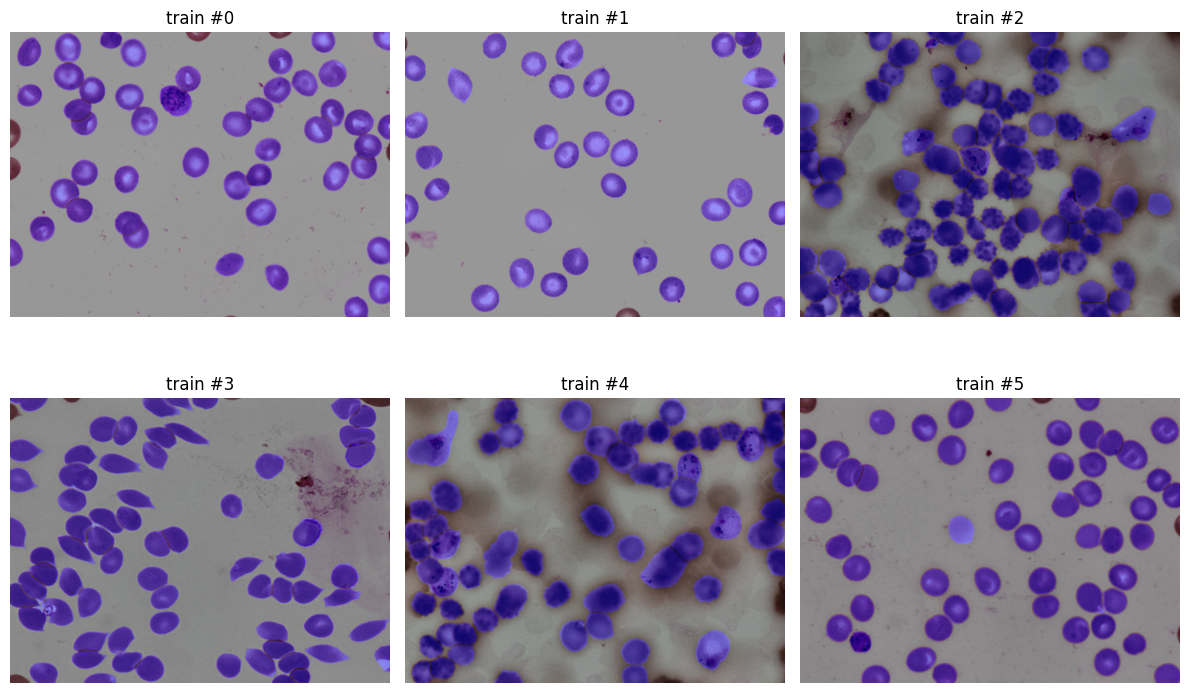

In [3]:
# =========================
# Step 1 — REPAIR / REBUILD SPLITS from current kagglehub root
# =========================
import os, json, random
from pathlib import Path
from typing import List, Tuple
import numpy as np
import cv2
from PIL import Image

def colorize_mask(msk, alpha=0.4, base=None):
    """
    Take a binary mask (0/255) and overlay a pseudo-color (red) on the base image.
    If no base is given, returns a colored mask.
    """
    import numpy as np
    import cv2

    # make sure mask is binary (0/1)
    mask = (msk > 0).astype(np.uint8)

    # convert mask to RGB (red color overlay)
    overlay = np.zeros((*mask.shape, 3), dtype=np.float32)
    overlay[..., 0] = mask  # red channel

    if base is None:
        return overlay

    # convert base to RGB and normalize
    if base.ndim == 2:
        base_rgb = np.stack([base]*3, axis=-1)
    else:
        base_rgb = cv2.cvtColor(base, cv2.COLOR_BGR2RGB)
    base_rgb = base_rgb.astype(np.float32) / 255.0

    # blend overlay with base
    blended = (1 - alpha) * base_rgb + alpha * overlay
    blended = np.clip(blended, 0, 1)
    return blended

def to_rgb(img_bgr: np.ndarray) -> np.ndarray:
    """
    Convert BGR uint8 image -> RGB float [0,1].
    If already grayscale, tile to 3 channels.
    """
    if img_bgr.ndim == 2:
        rgb = np.stack([img_bgr]*3, axis=-1)
    else:
        rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    rgb = rgb.astype(np.float32)
    if rgb.max() > 1.0:
        rgb /= 255.0
    return rgb


# --- robust readers (keep) ---
def read_image_bgr_safe(path: Path):
    img = cv2.imread(str(path), cv2.IMREAD_COLOR)
    if img is None:
        with Image.open(path) as im:
            im = im.convert("RGB")
            img = cv2.cvtColor(np.array(im), cv2.COLOR_RGB2BGR)
    return img

def read_mask_safe(path: Path):
    msk = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if msk is None:
        with Image.open(path) as im:
            im = im.convert("L")
            msk = np.array(im)
    if msk.dtype != np.uint8:
        msk = msk.astype(np.uint8)
    msk = (msk > 0).astype(np.uint8) * 255
    return msk

# --- prefer kagglehub, then fall back to /kaggle/input ---
try:
    import kagglehub
except Exception:
    kagglehub = None
    print("kagglehub not available. Install it or place dataset manually.")

def dataset_download_and_locate_clean():
    if kagglehub is None:
        raise RuntimeError("kagglehub not available.")
    path = kagglehub.dataset_download("jeetblahiri/bccd-dataset-with-mask")
    base = Path(path)
    if not base.exists():
        raise RuntimeError(f"kagglehub path not found: {base}")
    return base  # NOTE: return the kagglehub base; we will search recursively

def list_pairs_recursive(root: Path) -> List[Tuple[Path, Path]]:
    """
    Search *recursively* for any 'train/original' folder under 'root',
    and pair images with masks found next to it ('train/mask').
    """
    pairs_all: List[Tuple[Path, Path]] = []

    # find every '.../train/original' directory under root
    for img_dir in root.rglob("train/original"):
        msk_dir = img_dir.parent / "mask"
        if not msk_dir.exists():
            continue

        # Build a fuzzy mask matcher for this particular sub-dataset
        masks_by_stem = {}
        for mp in sorted(msk_dir.glob("*")):
            if not mp.is_file():
                continue
            stem = mp.stem
            masks_by_stem.setdefault(stem, []).append(mp)

        def find_mask_for(img_path: Path):
            s = img_path.stem
            # exact stem first
            if s in masks_by_stem:
                return masks_by_stem[s][0]
            # fuzzy: any mask starting with stem
            cands = list(msk_dir.glob(s + "*"))
            return cands[0] if cands else None

        for ip in sorted(img_dir.glob("*")):
            if not ip.is_file():
                continue
            if ip.suffix.lower() not in {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}:
                continue
            mp = find_mask_for(ip)
            if mp is not None:
                pairs_all.append((ip, mp))

    return pairs_all

def filter_readable_pairs(pairs: List[Tuple[Path, Path]]):
    good = []
    dropped = 0
    for ip, mp in pairs:
        try:
            _ = read_image_bgr_safe(ip)
            _ = read_mask_safe(mp)
            good.append((ip, mp))
        except Exception as e:
            print("Drop unreadable:", ip, mp, "|", e)
            dropped += 1
    return good, dropped

def make_splits_capped(pairs, total_max=MAX_IMAGES, ratios=RATIOS_SPLIT, seed=SEED):
    random.Random(seed).shuffle(pairs)
    pairs = pairs[:min(total_max, len(pairs))]
    n = len(pairs)
    n_tr = int(n * ratios[0]); n_va = int(n * ratios[1])
    return {"train": pairs[:n_tr], "val": pairs[n_tr:n_tr+n_va], "test": pairs[n_tr+n_va:]}

def save_splits_json(splits, out_json):
    ser = {k: [[str(p[0]), str(p[1])] for p in v] for k,v in splits.items()}
    with open(out_json, "w") as f: json.dump(ser, f)

def load_splits_json(json_path):
    with open(json_path) as f: raw = json.load(f)
    return {k: [(Path(a), Path(b)) for a,b in v] for k,v in raw.items()}

# ---------- Rebuild from CURRENT env (ignore stale /kaggle/input paths) ----------
FORCE_REBUILD = True  # <-- ensures we overwrite stale paths from other environments

if FORCE_REBUILD or (not os.path.exists(SPLITS_JSON)):
    base = dataset_download_and_locate_clean()
    print("kagglehub base:", base)

    # 1) scan recursively for valid sub-datasets
    pairs_all = list_pairs_recursive(base)
    print("Found total candidate pairs:", len(pairs_all))

    # 2) robust read filter
    pairs_good, dropped = filter_readable_pairs(pairs_all)
    print("Readable pairs:", len(pairs_good), "| dropped:", dropped)

    # 3) make small deterministic splits
    splits = make_splits_capped(pairs_good, total_max=MAX_IMAGES, ratios=RATIOS_SPLIT, seed=SEED)
    print("Split sizes:", {k: len(v) for k,v in splits.items()})
    save_splits_json(splits, SPLITS_JSON)
else:
    splits = load_splits_json(SPLITS_JSON)
    # if these paths point to another env (e.g., /kaggle/input), re-map by filename
    # build a filename->current-path map from the current kagglehub base
    base = dataset_download_and_locate_clean()
    all_files = {p.name: p for p in base.rglob("*") if p.is_file()}
    remapped = {}
    for split, items in splits.items():
        new_items = []
        for ip, mp in items:
            nip = all_files.get(Path(ip).name)
            nmp = all_files.get(Path(mp).name)
            if nip and nmp:
                new_items.append((nip, nmp))
        remapped[split] = new_items
    splits = remapped
    save_splits_json(splits, SPLITS_JSON)
    print("Remapped split sizes:", {k: len(v) for k,v in splits.items()})

print("Small split sizes (final):", {k: len(v) for k,v in splits.items()})

# --- preview using safe readers ---
def read_pair(img_path, msk_path):
    img = read_image_bgr_safe(img_path)
    msk = read_mask_safe(msk_path)
    return img, msk

def show_split_grid(splits, split="train", n=6, overlay=True, cols=3, alpha=0.4):
    items = splits[split][:n]
    rows = int(np.ceil(max(1, len(items))/cols))
    plt.figure(figsize=(4*cols, 4*rows))
    for i,(ip,mp) in enumerate(items):
        img, msk = read_pair(ip, mp)
        rgb = to_rgb(img)
        vis = to_rgb(colorize_mask(msk, alpha=alpha, base=img)) if overlay else np.hstack([rgb, np.stack([msk]*3,axis=-1)])
        ax = plt.subplot(rows, cols, i+1); ax.imshow(vis); ax.set_title(f"{split} #{i}"); ax.axis('off')
    plt.tight_layout(); save_or_show(f"step1_split_{split}.png")

# Try the grid (will be empty if dataset isn't accessible)
show_split_grid(splits, "train", n=6, overlay=True, cols=3)


## 3) Step 2 — Preprocessing: Reinhard stain normalization, patch extraction, augments

In [ ]:

def compute_reinhard_stats(img_bgr: np.ndarray):
    lab = color.rgb2lab(to_rgb(img_bgr)).astype(np.float32)
    means = lab.reshape(-1, 3).mean(axis=0)
    stds  = lab.reshape(-1, 3).std(axis=0) + 1e-6
    return means, stds

def reinhard_normalize(img_bgr: np.ndarray, target_means, target_stds):
    lab = color.rgb2lab(to_rgb(img_bgr)).astype(np.float32)
    src_means = lab.reshape(-1, 3).mean(axis=0)
    src_stds  = lab.reshape(-1, 3).std(axis=0) + 1e-6
    lab_norm = (lab - src_means) / src_stds * target_stds + target_means
    lab_norm[..., 0] = np.clip(lab_norm[..., 0], 0.0, 100.0)
    lab_norm[..., 1] = np.clip(lab_norm[..., 1], -128.0, 127.0)
    lab_norm[..., 2] = np.clip(lab_norm[..., 2], -128.0, 127.0)
    rgb_norm = (255.0 * np.clip(color.lab2rgb(lab_norm), 0.0, 1.0)).astype(np.uint8)
    return cv2.cvtColor(rgb_norm, cv2.COLOR_RGB2BGR)

ref_bgr = cv2.imread(str(splits["train"][0][0]), cv2.IMREAD_COLOR)
target_stats = compute_reinhard_stats(ref_bgr)

def preview_stain_norm(ip, mp=None, title=""):
    img = cv2.imread(str(ip), cv2.IMREAD_COLOR)
    norm = reinhard_normalize(img, *target_stats)
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(1,2,1); ax1.imshow(to_rgb(img));  ax1.set_title("Original"); ax1.axis('off')
    ax2 = fig.add_subplot(1,2,2); ax2.imshow(to_rgb(norm)); ax2.set_title("Reinhard"); ax2.axis('off')
    fig.suptitle(title); save_or_show("step2_reinhard_preview.png")
    if mp is not None:
        msk = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE)
        over_o = to_rgb(colorize_mask(msk, base=img)); over_n = to_rgb(colorize_mask(msk, base=norm))
        fig = plt.figure(figsize=(10,4))
        ax1 = fig.add_subplot(1,2,1); ax1.imshow(over_o); ax1.set_title("Original + Mask"); ax1.axis('off')
        ax2 = fig.add_subplot(1,2,2); ax2.imshow(over_n); ax2.set_title("Reinhard + Mask"); ax2.axis('off')
        fig.suptitle("Mask overlay before/after normalization"); save_or_show("step2_overlay_mask.png")

preview_stain_norm(*splits["train"][1], title="Stain normalization")

def preview_patch_extraction(ip, size=IMG_SIZE, tile=192):
    img = cv2.imread(str(ip), cv2.IMREAD_COLOR)
    h,w = img.shape[:2]
    y0 = max(0, (h-size)//2); x0 = max(0, (w-size)//2)
    crop = img[y0:y0+size, x0:x0+size]
    step = tile; tiles = []
    for yy in range(0, crop.shape[0]-tile+1, step):
        for xx in range(0, crop.shape[1]-tile+1, step):
            tiles.append(crop[yy:yy+tile, xx:xx+tile])
            if FAST_DEV and len(tiles)>=4: break
        if FAST_DEV and len(tiles)>=4: break
    rows = 2; cols = math.ceil(len(tiles)/rows)
    plt.figure(figsize=(4*cols,4*rows))
    for i,t in enumerate(tiles):
        ax = plt.subplot(rows, cols, i+1); ax.imshow(to_rgb(t)); ax.axis('off'); ax.set_title(f"tile {i}")
    plt.suptitle("Patch extraction preview"); save_or_show("step2_patch_preview.png")

preview_patch_extraction(splits["train"][0][0])

def build_train_transforms(size=IMG_SIZE):
    return A.Compose([
        A.Resize(height=size+32, width=size+32),
        A.RandomCrop(height=size, width=size, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.10, rotate_limit=10,
                           border_mode=cv2.BORDER_CONSTANT, p=0.4),
        A.GaussianBlur(blur_limit=(3,5), p=0.15),
        A.RandomBrightnessContrast(p=0.25),
        A.HueSaturationValue(p=0.25),
        ToTensorV2()
    ], additional_targets={'mask':'mask'})

def build_val_transforms(size=IMG_SIZE):
    return A.Compose([
        A.Resize(height=size, width=size),
        ToTensorV2()
    ], additional_targets={'mask':'mask'})

def preview_augments(ip, mp, n=6):
    tr = build_train_transforms(IMG_SIZE)
    img = cv2.imread(str(ip), cv2.IMREAD_COLOR)
    msk = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(12,4*math.ceil(n/3)))
    for i in range(n):
        out = tr(image=img, mask=msk)
        img_t = out["image"]; msk_t = out["mask"]
        rgb = (img_t.permute(1,2,0).float().cpu().numpy().clip(0,1)*255).astype(np.uint8)
        g   = (msk_t.cpu().numpy()>0).astype(np.uint8)*255
        over = colorize_mask(g, base=cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
        ax = plt.subplot(math.ceil(n/3), 3, i+1); ax.imshow(to_rgb(over)); ax.set_title(f"Aug #{i+1}"); ax.axis('off')
    plt.suptitle("Augmentation samples"); save_or_show("step2_aug_preview.png")

preview_augments(*splits["train"][2], n=6)


## 4) Step 3 — Model & Anchors (safe default; multi-size optional)

In [ ]:

def build_maskrcnn(num_classes=2, *, multi_size_per_level=False, sizes_single=(16,32,64,128,256),
                   sizes_multi=((8,12,16),(16,24,32),(32,48,64),(64,96,128),(128,192,256)),
                   aspect_ratios=(0.75,1.0,1.33), neutral_transform=True):
    m = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    if not multi_size_per_level:
        sizes = tuple((s,) for s in sizes_single)  # 1 size/level (SAFE: keeps default RPN head)
        ag = AnchorGenerator(sizes, (aspect_ratios,)*len(sizes))
        m.rpn.anchor_generator = ag
    else:
        sizes = sizes_multi  # 3 sizes/level -> need to rebuild RPN head
        ag = AnchorGenerator(sizes, (aspect_ratios,)*len(sizes))
        m.rpn.anchor_generator = ag
        in_channels = m.backbone.out_channels  # usually 256
        num_anchors = ag.num_anchors_per_location()[0]  # e.g., 9
        m.rpn.head = RPNHead(in_channels, num_anchors)

    # heads for 1 class (+ background)
    in_f = m.roi_heads.box_predictor.cls_score.in_features
    m.roi_heads.box_predictor  = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_f, num_classes)
    in_f_m = m.roi_heads.mask_predictor.conv5_mask.in_channels
    m.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_f_m, 256, num_classes)

    # neutral transforms because we feed [0,1]
    if neutral_transform:
        m.transform.image_mean = [0.0,0.0,0.0]
        m.transform.image_std  = [1.0,1.0,1.0]

    # RPN/ROI thresholds
    m.rpn.nms_thresh = 0.7
    m.rpn.pre_nms_top_n_train = 2000; m.rpn.post_nms_top_n_train = 1000
    m.rpn.pre_nms_top_n_test  = 1000; m.rpn.post_nms_top_n_test  = 1000
    m.roi_heads.score_thresh  = 0.0
    m.roi_heads.nms_thresh    = 0.5
    return m

# SAFE default: single size per level (prevents reshape crash)
model = build_maskrcnn(num_classes=2, multi_size_per_level=False).to(device)
print("Backbone: ResNet50-FPN | Anchors: single-size/level (safe)")

@torch.no_grad()
def visualize_anchors(model, img_path, num_show=300):
    model.eval()
    img_bgr = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    t = torchvision.transforms.functional.to_tensor(img_rgb).to(next(model.parameters()).device)
    images, _ = model.transform([t])
    feats = model.backbone(images.tensors)
    if isinstance(feats, dict): feats = list(feats.values())
    anchors = model.rpn.anchor_generator(images, feats)
    anc0 = anchors[0]
    A = anc0 if isinstance(anc0, torch.Tensor) else anc0.tensor
    A = A.detach().cpu().numpy().astype(int)
    H,W = img_rgb.shape[:2]
    vis = img_rgb.copy()
    for (x1,y1,x2,y2) in A[np.random.choice(len(A), size=min(num_show,len(A)), replace=False)]:
        x1,y1,x2,y2 = np.clip([x1,y1,x2,y2],[0,0,0,0],[W-1,H-1,W-1,H-1])
        cv2.rectangle(vis,(x1,y1),(x2,y2),(255,0,0),1)
    plt.figure(figsize=(7,6)); plt.imshow(vis); plt.title("Sample of RPN anchors"); plt.axis('off'); save_or_show("step3_anchor_preview.png")

visualize_anchors(model, splits["train"][0][0])


## 5) Step 4 — Dataset & Loader (semantic→instances) + viz

In [ ]:

def mask_to_instances(msk: np.ndarray, min_area=20):
    lbl = cc_label(msk > 0)
    boxes, masks, labels = [], [], []
    for p in regionprops(lbl):
        if p.area < min_area: continue
        masks.append((lbl == p.label).astype(np.uint8))
        boxes.append([p.bbox[1], p.bbox[0], p.bbox[3], p.bbox[2]])
        labels.append(1)
    if not masks:
        return [[0,0,1,1]], np.zeros((1, *msk.shape), np.uint8), [1]
    return boxes, np.stack(masks), labels

class BCCDInstanceDataset(Dataset):
    def __init__(self, pairs, target_stats=None, train=True, size=IMG_SIZE):
        self.pairs = pairs
        self.target_stats = target_stats
        self.train = train
        self.t = build_train_transforms(size) if train else build_val_transforms(size)
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = cv2.imread(str(ip), cv2.IMREAD_COLOR)
        msk = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE)
        if self.target_stats is not None:
            img = reinhard_normalize(img, *self.target_stats)
        data = self.t(image=img, mask=msk)
        img_t = data["image"].float()
        if img_t.max()>1.0: img_t = img_t/255.0
        msk_np = (data["mask"].cpu().numpy()>0).astype(np.uint8)
        boxes, masks, labels = mask_to_instances(msk_np, min_area=20)
        target = {
            "boxes":  torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "masks":  torch.as_tensor(masks, dtype=torch.uint8),
            "image_id": torch.tensor([idx]),
            "area": torch.as_tensor([m.sum() for m in masks], dtype=torch.float32),
            "iscrowd": torch.zeros((len(masks),), dtype=torch.int64),
        }
        return img_t, target

def collate_fn(batch): return tuple(zip(*batch))

train_ds = BCCDInstanceDataset(splits["train"], target_stats, train=True,  size=IMG_SIZE)
val_ds   = BCCDInstanceDataset(splits["val"],   target_stats, train=False, size=IMG_SIZE)

train_loader = DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True,
                          num_workers=NUM_WORK, collate_fn=collate_fn, pin_memory=torch.cuda.is_available())
val_loader   = DataLoader(val_ds, batch_size=BATCH_SZ, shuffle=False,
                          num_workers=NUM_WORK, collate_fn=collate_fn, pin_memory=torch.cuda.is_available())

def _to_uint8_rgb(img_t): return (img_t.detach().cpu().clamp(0,1).permute(1,2,0).numpy()*255).astype(np.uint8)

def overlay_instances(img_rgb, masks, boxes=None, alpha=0.45):
    out = img_rgb.copy()
    for m in masks:
        if m.max()==0: continue
        col = np.random.randint(64,255, size=(3,), dtype=np.uint8)
        out[m.astype(bool)] = ((1-alpha)*out[m.astype(bool)] + alpha*col).astype(np.uint8)
    if boxes is not None:
        if torch.is_tensor(boxes): boxes = boxes.cpu().numpy()
        for (x1,y1,x2,y2) in boxes.astype(int):
            cv2.rectangle(out,(x1,y1),(x2,y2),(255,0,0),2)
    return out

def visualize_dataset_item(ds, idx=0):
    img_t, tgt = ds[idx]
    img = _to_uint8_rgb(img_t)
    masks = tgt["masks"].cpu().numpy().astype(np.uint8)
    boxes = tgt["boxes"]
    vis = overlay_instances(img, masks, boxes)
    plt.figure(figsize=(6,5)); plt.imshow(vis); plt.title(f"Dataset item {idx}: {len(masks)} instances"); plt.axis('off')
    save_or_show(f"step4_dataset_item_{idx}.png")

visualize_dataset_item(train_ds, idx=0)


## 6) Step 5 — Train & Evaluate (IoU, Dice, mAP@0.5 proxy)

In [ ]:

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=LR, weight_decay=1e-4)
lr_sched  = torch.optim.lr_scheduler.StepLR(optimizer, step_size=max(1,EPOCHS//2), gamma=0.5)
scaler = GradScaler('cuda', enabled=USE_AMP)
history = {"loss":[], "lr":[]}

def train_one_epoch(epoch):
    model.train()
    running, t0 = 0.0, time.time()
    for step, (imgs, tgts) in enumerate(train_loader, 1):
        imgs = [im.to(device) for im in imgs]
        tgts = [{k:(v.to(device) if isinstance(v, torch.Tensor) else v) for k,v in t.items()} for t in tgts]
        optimizer.zero_grad(set_to_none=True)
        with autocast('cuda', enabled=USE_AMP):
            losses = model(imgs, tgts)
            loss = sum(losses.values())
        scaler.scale(loss).backward()
        scaler.step(optimizer); scaler.update()
        running += loss.item()
        if step % PRINT_EVERY == 0:
            comp = " | ".join([f"{k}:{v.item():.3f}" for k,v in losses.items()])
            print(f"Epoch {epoch} [{step}/{len(train_loader)}] loss={loss.item():.4f} | {comp}")
    lr_sched.step()
    avg = running / max(1,len(train_loader))
    history["loss"].append(avg); history["lr"].append(optimizer.param_groups[0]["lr"])
    print(f"Epoch {epoch} done in {time.time()-t0:.1f}s, avg loss {avg:.4f}")
    torch.save({"epoch":epoch, "model":model.state_dict(), "opt":optimizer.state_dict()}, f"{CKPT_DIR}/epoch_{epoch}.pt")

def plot_training_curves():
    plt.figure(figsize=(6,4))
    plt.plot(history["loss"], marker='o'); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Train loss")
    save_or_show("step5_train_loss.png")

def iou_score(pm, gm):
    inter = (pm & gm).sum(); union = (pm | gm).sum()
    return (inter/union) if union>0 else 1.0

def dice_score(pm, gm, eps=1e-6):
    inter = (pm & gm).sum()
    return (2*inter) / (pm.sum()+gm.sum()+eps)

def masks_to_boxes(masks):
    boxes = []
    for m in masks:
        ys, xs = np.where(m>0)
        if len(xs)==0: boxes.append([0,0,1,1])
        else: boxes.append([xs.min(), ys.min(), xs.max(), ys.max()])
    return np.array(boxes, dtype=np.float32)

def ap_at_05(pred_boxes, true_boxes):
    if len(pred_boxes)==0 and len(true_boxes)==0: return 1.0
    if len(pred_boxes)==0 or len(true_boxes)==0:  return 0.0
    tb = true_boxes.copy().tolist(); tp = 0
    for pb in pred_boxes:
        best, jbest = 0.0, -1
        for j,gb in enumerate(tb):
            xA = max(pb[0], gb[0]); yA = max(pb[1], gb[1])
            xB = min(pb[2], gb[2]); yB = min(pb[3], gb[3])
            inter = max(0, xB-xA+1) * max(0, yB-yA+1)
            area_p = (pb[2]-pb[0]+1)*(pb[3]-pb[1]+1)
            area_g = (gb[2]-gb[0]+1)*(gb[3]-gb[1]+1)
            iou = inter / (area_p + area_g - inter + 1e-6)
            if iou>best: best, jbest = iou, j
        if best>=0.5: tp += 1; tb.pop(jbest)
    return tp / max(1,len(pred_boxes))

@torch.no_grad()
def evaluate_model(n_batches=5):
    model.eval()
    ious, dices, aps = [], [], []
    for bi, (imgs, tgts) in enumerate(val_loader, 1):
        imgs = [im.to(device) for im in imgs]
        outs = model(imgs)
        for k in range(len(imgs)):
            pm = outs[k]["masks"].detach().cpu().numpy()
            pm = (pm[:,0]>0.5).astype(np.uint8) if pm.size>0 else np.zeros((0, IMG_SIZE, IMG_SIZE), np.uint8)
            gm = tgts[k]["masks"].numpy().astype(np.uint8)
            pred_union = (pm.sum(axis=0)>0).astype(np.uint8)
            true_union = (gm.sum(axis=0)>0).astype(np.uint8)
            ious.append(iou_score(pred_union, true_union))
            dices.append(dice_score(pred_union, true_union))
            aps.append(ap_at_05(masks_to_boxes(pm), masks_to_boxes(gm)))
        if FAST_DEV and bi>=n_batches: break
    return float(np.mean(ious)), float(np.mean(dices)), float(np.mean(aps))

# ---- Train (short) ----
for epoch in range(1, EPOCHS+1):
    train_one_epoch(epoch)

plot_training_curves()
mean_iou, mean_dice, mean_map = evaluate_model()
print(f"Validation — IoU: {mean_iou:.3f} | Dice: {mean_dice:.3f} | mAP@0.5 (proxy): {mean_map:.3f}")

plt.figure(figsize=(5,4))
plt.bar(["IoU","Dice","mAP@0.5"], [mean_iou, mean_dice, mean_map]); plt.title("Validation metrics")
save_or_show("step5_metrics_bar.png")


## 7) Step 6 — Qualitative overlays: successes vs failures

In [ ]:

@torch.no_grad()
def overlay_predictions(img_t, out):
    img = _to_uint8_rgb(img_t)
    if out["masks"].numel()==0: return img, 0
    pm = (out["masks"].cpu().numpy()[:,0]>0.5).astype(np.uint8)
    vis = overlay_instances(img, pm, out["boxes"])
    return vis, pm.sum()

@torch.no_grad()
def collect_qualitative_panels(n=6):
    model.eval(); samples = []
    for imgs, tgts in val_loader:
        imgs = [im.to(device) for im in imgs]
        outs = model(imgs)
        for k in range(len(imgs)):
            vis, _ = overlay_predictions(imgs[k].cpu(), outs[k])
            pm = outs[k]["masks"].cpu().numpy()
            pm = (pm[:,0]>0.5).astype(np.uint8) if pm.size>0 else np.zeros((0, IMG_SIZE, IMG_SIZE), np.uint8)
            gm = tgts[k]["masks"].numpy().astype(np.uint8)
            iou = iou_score((pm.sum(axis=0)>0),(gm.sum(axis=0)>0))
            samples.append((vis, iou))
        if FAST_DEV and len(samples) > (n*4): break
    samples.sort(key=lambda x: x[1], reverse=True)
    best, worst = samples[:n], (samples[-n:] if len(samples)>=n else samples[-len(samples):])
    def panel(items, title, fname):
        cols = 3; rows = math.ceil(len(items)/cols)
        plt.figure(figsize=(4*cols,4*rows))
        for i,(im,score) in enumerate(items):
            ax = plt.subplot(rows, cols, i+1); ax.imshow(im); ax.set_title(f"IoU={score:.2f}"); ax.axis('off')
        plt.suptitle(title); save_or_show(fname)
    panel(best,  "Success cases (top IoU)", "step6_success_cases.png")
    panel(worst, "Failure cases (low IoU)", "step6_failure_cases.png")

collect_qualitative_panels(n=6)
print("All done ✅")
